# Übungen Recurrent Neuronal Networks (Hausaufgabe #5.1)

Aufgabe

1. Trainiert RNN mit den Bildern aus Eurer letzten Hausaufgabe
  - Analysiert das Verhalten mit unterschiedlichen Hyperparametern (Anzahl Hidden Layers, Anzahl Neuronen, ...)
  - Farbbilder können nicht 1:1 verwendet werden. Versucht daher unterschiedliche Varianten (Minimum schwarz/weis Konvertierung.
2. Training mit richtiger Timeserie ist in separater Datei.

## Übungssetup

### Teammitglieder Gruppe 3

- Hans Wermelinger
- Helmut Gehrer
- Markus Näpflin
- Nils Hryciuk
- Stefano Mavilio

### Laufzeitumgebung

Damit dieses Jupyter-Notebook ausgeführt werden kann, müssen folgende Module im aktuellen Python-Environment verfügbar sein:

- numpy
- math
- torch
- matplotlib
- pandas
- ucimlrepo
- torchviz

Alternativ kann es auch auf [Google Collab](https://colab.research.google.com/drive/1tohtPXhmdNVGt63S1VPErbeQK1YJNoMr?usp=sharing#scrollTo=78b7wKOj-hwB) ausgeführt werden.

## Lösungsweg

### Daten

#### Herkunft

[Kaggle - 70 Dog Breeds-Image Data Set](https://www.kaggle.com/datasets/gpiosenka/70-dog-breedsimage-data-set/data)
#### Context

I own a dog grooming business. A lot of customers don't know the breed of their dog. I am no expert either so I developed an AI program that can identify the breed of a dog from a photo. It works well for pure bred dogs and also seems to work reasonably well for mixed breeds. For each prediction I list the probability of the most likely breed and the probability of the next most likely breed. I tried that on my dog who is a mix of a Rottweiler and a Doberman. It came back that there as a 62% probability it was a Rottweiler and a 28% probability it was a Doberman.

#### Content

Data was gathered from internet searches on a specific dog breed. Images were than downloaded and checked for accuracy as not all the images you get in a search are correct. Then the downloaded images were scanned for duplicates using a duplicate image detection program I developed. All duplicates were removed to prevent any images being duplicate across the test, train and validation sets. Images were then resized to 224 X 224 X 3 and put in jpg format.

### Vorbereitung Notebook


#### Generelle Konfigurationen

Generelle Importe

In [1]:
# --- Sicherstellen, dass alle benötigten Libraries vorhanden sind
%pip install torch torchvision torchmetrics graphviz torchviz numpy matplotlib kagglehub

Note: you may need to restart the kernel to use updated packages.


In [2]:

# --- generelle Importe ---
import os
from datetime import datetime, timedelta
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Setzen diverser Konstanten

In [ ]:
# --- Diverse Konstanten vordefinieren ---
MODEL_DTYPE = torch.float # Datentyp für Tensoren
DEFAULT_SEED = 42 # Konstante für reproduzierbare Zufahlszahlen
IMAGE_EDGE_LENGTH = 224 # Kantenlänge der quadratischen Bilder in Pixel.
HOMEWORK_PREFIX = 'AI.1.4-' # Präfix für die Bezeichnung der Hausaufgaben (für Arbeitsdateien)

print('Following constants have been initialized:')
print(f'- MODEL_DTYPE: {MODEL_DTYPE}')
print(f'- DEFAULT_SEED: {DEFAULT_SEED}')
print(f'- IMAGE_SIZE (IMAGE_EDGE_SIZE): {IMAGE_EDGE_LENGTH}x{IMAGE_EDGE_LENGTH} pxl')

Following constants have been initialized:
- MODEL_DTYPE: torch.float32
- DEFAULT_SEED: 42
- IMAGE_SIZE (IMAGE_EDGE_SIZE): 224x224 pxl


Konfiguration von PyTorch und Mathplotlib

In [4]:
# --- Konfiguration von PyTorch ---
FASTEST_DEVICE = {
    torch.cuda.is_available(): 'cuda', # GPU
    torch.backends.mps.is_available(): 'mps' # Metal-Performance-Service, z.B. Mac Mx;
}.get(True, 'cpu')
torch.set_default_device(FASTEST_DEVICE)
torch.set_default_dtype(MODEL_DTYPE)
torch.manual_seed(DEFAULT_SEED)

print('Torch has bee configured as follows:')
print(f'- seed: {DEFAULT_SEED}')
print(f'- fastest device: {FASTEST_DEVICE}')
# --- Plotter initialisieren inkl. Inline-Ausgabe der Grafiken ---
plt.rcdefaults()
%matplotlib inline
print('Matplotlib has been configured for inline display.')

Torch has bee configured as follows:
- seed: 42
- fastest device: mps
Matplotlib has been configured for inline display.


### Herunterladen der Daten von Kagglehub
Laden des Datasets direkt von Kaggle.com mithilfe des verfügbaren Loaders aus dem Modul kagglehub.

*Diesmal in einfacher Version. Im Gegensatz zu Übung 4 werden die Daten dort belassen, wohin sie vom Plugin geladen worden sind. Wir haben keine zusätzlichen Dateien, die wir im Projektkontext ablegen wollen. Auch nehmen wird diesmal die aktuellste Version des Datasets.*

In [5]:
import kagglehub

download_path = kagglehub.dataset_download('gpiosenka/70-dog-breedsimage-data-set')
print(f'Dataset files are available at {download_path}.')

Dataset files are available at /Users/helmut/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2.


### Laden des Datasets inkl Split train/valid/test

#### Funktion zum Transformieren der Daten und Bereitstellung als Loader

Diese Funktion stellt die vorgängig herungergeladenen Daten aus dem Verezichnis als Dataloader bereit. Dabei werden die Daten

- transformiert (Resize konfigurierbar)
- in drei Dataloaders (trein / test / validate) bereitgestellt. Die Batchgrösse ist hier ebenfalls konfigurierbar.

In [6]:
# --- Datensets train / validate / test laden ---
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets


def prepare_dataloaders(batch_size=5, edge_length=IMAGE_EDGE_LENGTH, crop_size = IMAGE_EDGE_LENGTH):
    data_transforms = {
        'train': transforms.Compose([
            transforms.CenterCrop(crop_size),
            transforms.Resize(edge_length),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
            # Farbe transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'valid': transforms.Compose([
            transforms.CenterCrop(crop_size),
            transforms.Resize(edge_length),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
            # RGB transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.CenterCrop(crop_size),
            transforms.Resize(edge_length),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
            # RGBtransforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }

    generator = torch.Generator(device=FASTEST_DEVICE)
    generator.manual_seed(DEFAULT_SEED)

    image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(download_path, x), data_transforms[x]) for x in ['train', 'valid', 'test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, generator=generator, num_workers=0) for x in ['train', 'valid', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
    print(f'Dataset mit folgenden Grössen sind verfügbar: {dataset_sizes}')
    class_names = image_datasets['train'].classes
    return dataloaders, class_names

#### Testen des Dataloaders

Aufruf der Funktion und anzeige eines Batches Bilder aus dem Trainingsdatensatz.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Dataset mit folgenden Grössen sind verfügbar: {'train': 7946, 'valid': 700, 'test': 700}


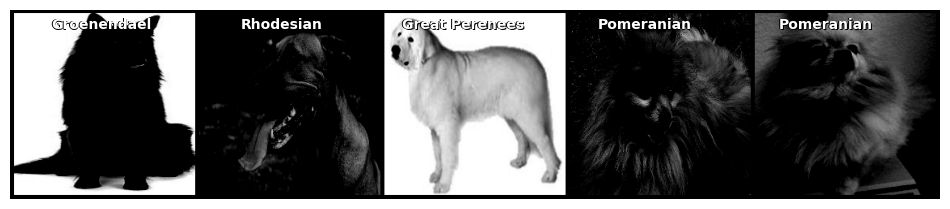

In [7]:
# functions to show an image
def add_image_to_grid(image):
    image = image / 2 + 0.5     # unnormalize
    npimg = image.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

debug_dataloaders, debug_dog_breeds = prepare_dataloaders()
#debug_dataloaders, debug_dog_breeds = prepare_dataloaders(batch_size=15, edge_length=112)
debug_images, debug_labels = next(iter(debug_dataloaders['train']))
grid_img = torchvision.utils.make_grid(debug_images, nrow=5, padding=5)

plt.figure(figsize=(12, 6))
plt.imshow(grid_img.permute(1, 2, 0))  # permute für korrektes Format (H, W, C)
plt.axis('off')

# Labels unter den Bildern anbringen
num_images = len(debug_labels)
nrow = 5
for batch_number in range(num_images):
    row = batch_number // nrow
    col = batch_number % nrow
    x_pos = col * (debug_images.size(3)) + debug_images.size(3) // 2
    y_pos = row * debug_images.size(2) + 10
    # Test mit Umrandung rendern durch versetztes Plotten.
    plt.text(x_pos-1, y_pos-1, debug_dog_breeds[debug_labels[batch_number]], ha='center', va='top', color='black', fontsize=10, fontweight='bold')
    plt.text(x_pos+1, y_pos+1, debug_dog_breeds[debug_labels[batch_number]], ha='center', va='top', color='black', fontsize=10, fontweight='bold')
    plt.text(x_pos, y_pos, debug_dog_breeds[debug_labels[batch_number]], ha='center', va='top', color='white', fontsize=10, fontweight='bold')

plt.show()

### Defintion des Modells

#### Modellklasse DogBreedRnnModel

In [8]:
class DogBreedRnnModel(nn.Module):
    def __init__(self, image_edge_length=IMAGE_EDGE_LENGTH, recall_depth=IMAGE_EDGE_LENGTH, hidden_layer_nodes=1024, output_size=70):
        """
        Instanziert die Modell-Klasse
        @param
        ghe todo:
        """
        super().__init__()
        self.hidden_dim = recall_depth # Hidden dimensions
        self.layer_dim = hidden_layer_nodes # Number of hidden layers
        self.rnn = nn.RNN(image_edge_length, recall_depth, hidden_layer_nodes, batch_first=True, nonlinearity='relu') #        
        self.fc = nn.Linear(recall_depth, output_size) # Readout layer
        self.output_size = output_size # Anzahl der Klassen des Outputs (für die Klassifikation)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()  # Initialize hidden state with zeros
        out, hn = self.rnn(x, h0.detach())  # Detach hidden state  (truncated backpropagation through time (BPTT))
        out = self.fc(out[:, -1, :]) # Index hidden state of last time step
        return out
    
    def is_batch_supported(self):
        return False
    


#### Modellklasse DogBreedCnnModel

In [9]:
# --- für Performance-Vergleich -- DogBreedCnnModel ---

import torch.nn.functional as F
class DogBreedCnnModel(nn.Module):
    def __init__(self,image_edge_length=IMAGE_EDGE_LENGTH, hidden_layer_nodes=1024, output_size=70):
        super().__init__()
        #print('Erstelle neue Instanz von DogBreedCnnModel:')
        self.convolutional_1 = nn.Conv2d(1, 3, 3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.convolutional_2 = nn.Conv2d(self.convolutional_1.out_channels, 9, 5, stride=2, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=5, stride=2, padding=2)
        # Berechne die Dimensionen für die Flatten-Schicht
        conv_output_size = image_edge_length // 2 // 2
        flattened_size = self.convolutional_2.out_channels * conv_output_size * conv_output_size
        self.hidden_layer = nn.Linear(flattened_size, hidden_layer_nodes)
        self.output_layer = nn.Linear(hidden_layer_nodes, output_size)
        self.output_size = output_size # Anzahl der Klassen des Outputs (für die Klassifikation)

    def forward(self, x):
        x = self.pool1(F.relu(self.convolutional_1(x)))
        x = self.pool2(F.relu(self.convolutional_2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.hidden_layer(x))
        return self.output_layer(x)
    
    def is_batch_supported(self):
        return True

In [10]:
# --- Debug-Code ---
debug_cnn = DogBreedCnnModel(56, 256, 70).to(FASTEST_DEVICE)
debug_dataloaders, debug_dog_breeds = prepare_dataloaders(batch_size=1, edge_length=56)
debug_images, debug_labels = next(iter(debug_dataloaders['train']))
debug_images = debug_images.to(FASTEST_DEVICE)  
debug_con1 = debug_cnn.convolutional_1(debug_images)
print(f'convolutional_1: {debug_con1.shape}')
debug_pool1 = debug_cnn.pool1(debug_con1)
print(f'pool1: {debug_pool1.shape}')
debug_con2 = debug_cnn.convolutional_2(debug_pool1)
print(f'convolutional_2: {debug_con2.shape}')
debug_pool2 = debug_cnn.pool2(debug_con2)
print(f'pool2: {debug_pool2.shape}')    
debug_flattened = torch.flatten(debug_pool2, 1)
print(f'flattened: {debug_flattened.shape}; expected: 9*14*14=1764')    


Dataset mit folgenden Grössen sind verfügbar: {'train': 7946, 'valid': 700, 'test': 700}
convolutional_1: torch.Size([1, 3, 56, 56])
pool1: torch.Size([1, 3, 56, 56])
convolutional_2: torch.Size([1, 9, 28, 28])
pool2: torch.Size([1, 9, 14, 14])
flattened: torch.Size([1, 1764]); expected: 9*14*14=1764


#### Loss-Function

In [12]:
def build_loss_function(name):
    if name == 'CrossEntropyLoss':
        return nn.CrossEntropyLoss()
    elif name == 'MSELoss':
        return nn.MSELoss()
    elif name == 'NLLLoss':
        return nn.NLLLoss()

#### Optimzier

In [13]:
import torch.optim as optim

def build_optimizer(name, model):
    if name == 'SGD':
        return optim.SGD(model.parameters(), lr=0.001)
    elif name == 'Adam':
        return optim.Adam(model.parameters(), lr=0.001)


In [14]:
from numpy import mean
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score

# Training loop
def perform_training(label, epoch, dataloader, model, loss_function, optimizer, dry_run=False):
    start_timestamp = datetime.now()
    print(f'Training gestartet für Epoch {epoch} um {start_timestamp.strftime("%H:%M:%S")}')    
    total_train = 0
    for batch_number, (images, labels) in enumerate(dataloader):
        images = images.to(FASTEST_DEVICE) #.squeeze(0)  # Entfernt die erste Dimension (Batch-Größe 1)
        if not model.is_batch_supported():
            images = images.squeeze(0)
        labels = labels.to(FASTEST_DEVICE)
        model.train()
        # Load images as tensors with gradient accumulation abilities
        #images = images.reshape(-1, seq_dim, input_dim).requires_grad_()
        optimizer.zero_grad() # Clear gradients w.r.t. parameters
        outputs = model(images) # Forward pass to get output/logits
        loss = loss_function(outputs, labels) # Calculate Loss: softmax --> cross entropy loss
        loss.backward() # Getting gradients w.r.t. parameters
        optimizer.step() # Updating parameters
        total_train += labels.size(0)
        if dry_run and total_train > 4:
            print(f'❎ "{label}" #{epoch}.{batch_number+1} Abbruch, bei {total_train} Bildern, da Flag dry_run gesetzt ist.')
            break   
        if (batch_number + 1) % 100 == 0:
            print(f'Training "{label}" #{epoch}.{batch_number + 1} - Loss: {loss.item():.5f} bei {total_train} Bildern')
    end_timestamp = datetime.now()
    train_time = end_timestamp - start_timestamp
    print (f'✅ Training abgeschlossen um {end_timestamp.strftime("%H:%M:%S")}, Dauer: {train_time}')    
    return train_time

# Validation / Test loop (Kann für beide Datasets verwendet werden)
def perform_validation(label, mode, epoch, dataloader, model, dry_run=False):
    print (f'{mode} gestartet für Epoch {epoch}')
    accuracy_evaluator = Accuracy(task="multiclass", num_classes=model.output_size)
    f1_score_evaluator = F1Score(task="multiclass", num_classes=model.output_size)
    total_tests = 0
    correct_tests = 0
    accuracy_performance = []
    f1_score_performance = []
    with torch.no_grad():
        for batch_number, (images, labels) in enumerate(dataloader):
            if not model.is_batch_supported():
                images = images.squeeze(0)
            predictions = model(images.to(FASTEST_DEVICE))
            _, best_rated_prediction = torch.max(predictions, 1)
            for batch_result in range(0, best_rated_prediction.size(dim=0)):
                #print(f'Batch #{batch_result} liefert {best_rated_prediction[batch_result]}; erwartet war {labels[batch_result]}')
                total_tests += 1
                if (best_rated_prediction[batch_result] == labels[batch_result]):
                    correct_tests += 1
                    #true_positives[best_rated_prediction[batch_result]] += 1
                #else:
                    #false_positives[best_rated_prediction[batch_result]] += 1
            accuracy = accuracy_evaluator(predictions, labels)
            f1_score = f1_score_evaluator(predictions, labels)
            accuracy_performance.append(accuracy.item())
            f1_score_performance.append(f1_score.item())
            if dry_run and total_tests > 4:
                print(f'❎ "{label}" #{epoch}.{batch_number+1} Abbruch, bei {total_tests} Bildern, da Flag dry_run gesetzt ist.')
                break
            if (batch_number + 1) % 10 == 0:
                mean_accuracy = mean(accuracy_performance)  
                print(f'{mode} "{label}" #{epoch}.{batch_number + 1} - Korrekt {correct_tests}, accuracy {mean_accuracy:.5f}, bei {total_tests} Bildern')
                # print(f'{mode} "{label}" #{epoch}.{batch_number + 1} - Korrekt {correct_tests} bei {total_tests} Bildern')
    return total_tests, correct_tests, images


In [ ]:
# --- Ausführung ---
dry_run = True # Analyse-Modus mit wenig Samples. True nimmt nur die ersten 3; False, alle Bilder zu verarbeiten; 
image_batch_size = 1 # Wir wollen nur ein Bild pro Durchlauf analysieren
image_edge_length = 56
hidden_layer_nodes = 70
hidden_layer_nodes_x10 = 700 # 10x so viele wie die Anzahl der Klassen
max_epochs = 10
optimizer_name = 'Adam'
loss_function_name = 'CrossEntropyLoss'
dataloaders, dog_breeds = prepare_dataloaders(batch_size=image_batch_size, edge_length=image_edge_length)
dog_breed_count = len(dog_breeds)

loss_function = build_loss_function(loss_function_name)

# --- Rnn Modell "normal" --- 
rnn_model = DogBreedRnnModel(image_edge_length, image_edge_length, image_edge_length, dog_breed_count).to(FASTEST_DEVICE)
rnn_model_name = f'RNN_{image_edge_length}x{image_edge_length}x{image_edge_length}'
print(rnn_model)
rnn_optimizer = build_optimizer(optimizer_name, rnn_model)
rnn_train_performance = []
rnn_train_time = timedelta(0)
for epoch in range(1, max_epochs):
    rnn_epoch_train_time = perform_training(rnn_model_name, epoch, dataloaders['train'], rnn_model, loss_function, rnn_optimizer, dry_run=dry_run)
    rnn_train_time += rnn_epoch_train_time
    rnn_epoch_total_tests, rnn_epoch_correct_tests, _ = perform_validation(rnn_model_name, 'Test', epoch, dataloaders['test'], rnn_model, dry_run=dry_run)    
    rnn_train_performance.append(rnn_epoch_correct_tests)
total_rnn_validations, correct_rnn_validations, last_rnn_image_batch = perform_validation(rnn_model_name, 'Validation', 'final', dataloaders['valid'], rnn_model)  

# --- Rnn Modell "Small" --- 
short_term_memory = image_edge_length // 4 
rnn_s_model = DogBreedRnnModel(image_edge_length, short_term_memory, hidden_layer_nodes, dog_breed_count).to(FASTEST_DEVICE)
rnn_s_model_name = f'RNN_{image_edge_length}x{short_term_memory}x{hidden_layer_nodes}'
print(rnn_s_model)
rnn_s_optimizer = build_optimizer(optimizer_name, rnn_s_model)
rnn_s_train_performance = []
rnn_s_train_time = timedelta(0)
for epoch in range(1, max_epochs):
    rnn_s_epoch_train_time = perform_training(rnn_s_model_name, epoch, dataloaders['train'], rnn_s_model, loss_function, rnn_s_optimizer, dry_run=dry_run)
    rnn_s_train_time += rnn_s_epoch_train_time
    rnn_s_epoch_total_tests, rnn_s_epoch_correct_tests, _ = perform_validation(rnn_s_model_name, 'Test', epoch, dataloaders['test'], rnn_s_model, dry_run=dry_run)
    rnn_s_train_performance.append(rnn_s_epoch_correct_tests)
total_rnn_s_validations, correct_rnn_s_validations, last_rnn_s_image_batch = perform_validation(rnn_s_model_name, 'Validation', 'final', dataloaders['valid'], rnn_s_model)    

# --- Cnn Modell "Vergleich" ---
cnn_model = DogBreedCnnModel(image_edge_length, hidden_layer_nodes_x10, dog_breed_count).to(FASTEST_DEVICE)
cnn_model_name = f'CNN_{image_edge_length}x{hidden_layer_nodes_x10}'    
print(cnn_model)
cnn_optimizer = build_optimizer(optimizer_name, cnn_model)
cnn_train_performance = []
cnn_train_time = timedelta(0)
for epoch in range(1, max_epochs):
    cnn_epoch_train_time = perform_training(cnn_model_name, epoch, dataloaders['train'], cnn_model, loss_function, cnn_optimizer, dry_run=dry_run)
    cnn_train_time += cnn_epoch_train_time
    cnn_epoch_total_tests, cnn_epoch_correct_tests, _ = perform_validation(cnn_model_name, 'Test', epoch, dataloaders['test'], cnn_model, dry_run=dry_run)
    cnn_train_performance.append(cnn_epoch_correct_tests)
total_cnn_validations, correct_cnn_validations, last_cnn_image_batch = perform_validation(cnn_model_name, 'Validation', 'final', dataloaders['valid'], cnn_model)

print(f'🍻 Training beendet.')
print(f'   {rnn_model_name} benötigte {rnn_train_time} und hatte {correct_rnn_validations} korrekte Validations bei {total_rnn_validations} Bildern.')
print(f'   {rnn_s_model_name} benötigte {rnn_s_train_time} und hatte {correct_rnn_s_validations} korrekte Validations bei {total_rnn_s_validations} Bildern.')
print(f'   {cnn_model_name} benötigte {cnn_train_time} und hatte {correct_cnn_validations} korrekte Validations bei {total_cnn_validations} Bildern.')



Dataset mit folgenden Grössen sind verfügbar: {'train': 7946, 'valid': 700, 'test': 700}
DogBreedRnnModel(
  (rnn): RNN(56, 56, num_layers=56, batch_first=True)
  (fc): Linear(in_features=56, out_features=70, bias=True)
)
Training gestartet für Epoch 1 um 10:59:34
❎ "RNN_56x56x56" #1.5 Abbruch, bei 5 Bildern, da Flag dry_run gesetzt ist.
✅ Training abgeschlossen um 10:59:39, Dauer: 0:00:05.125777
Test gestartet für Epoch 1
❎ "RNN_56x56x56" #1.5 Abbruch, bei 5 Bildern, da Flag dry_run gesetzt ist.
Training gestartet für Epoch 2 um 10:59:41
❎ "RNN_56x56x56" #2.5 Abbruch, bei 5 Bildern, da Flag dry_run gesetzt ist.
✅ Training abgeschlossen um 10:59:46, Dauer: 0:00:05.076059
Test gestartet für Epoch 2
❎ "RNN_56x56x56" #2.5 Abbruch, bei 5 Bildern, da Flag dry_run gesetzt ist.
Training gestartet für Epoch 3 um 10:59:47
❎ "RNN_56x56x56" #3.5 Abbruch, bei 5 Bildern, da Flag dry_run gesetzt ist.
✅ Training abgeschlossen um 10:59:52, Dauer: 0:00:05.083506
Test gestartet für Epoch 3
❎ "RNN_56x56x

### Visualisierungen der Modelle

In [19]:
# --- Definition einiger Werte für die durchgängige Darstellung der Grafiken ---
PLOT_WIDTH = 16 # Breite der Plots
PLOT_HEIGHT = 9 # Höhe der Plots

rnn_model_color = '#EB4000' # coral
rnn_s_model_color = '#FB8900' # senfgelb
cnn_model_color = '#00A0Af' # Petrol


#### Modell-Graphen

Die nachfolgende Funktion dient dazu, Modellgraphen auszugeben. 

In [ ]:
from torchviz import make_dot
def plot_model_visualisation (model_name, model, input_data):
    model = model.to(FASTEST_DEVICE)
    input_data = input_data.to(FASTEST_DEVICE)
    output = model(input_data).to(FASTEST_DEVICE)
    dot = make_dot(output, params=dict(model.named_parameters())) 
    dot.format = 'png'
    image_name = HOMEWORK_PREFIX + model_name + '_visualisation.gv'
    dot.render(image_name)
    plt.title(f'Visualisierung {model_name}')
    plt.imshow(plt.imread(image_name + '.png'))
    plt.axis('off')
    plt.show()

In [27]:
# fixme: RNN Modell ist noch zu komplex für die Visualisierung. Hier benötigen wir ein einfacheres Modell ohne Reverse-Verbindungen.
# plot_model_visualisation (rnn_s_model_name, rnn_s_model, last_rnn_s_image_batch)

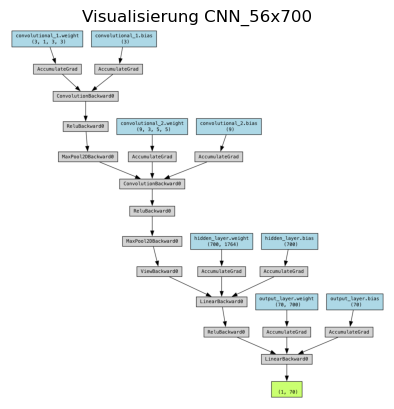

In [17]:
plot_model_visualisation (cnn_model_name, cnn_model, last_cnn_image_batch)

#### Trainingsressourcen

Bei der Ausgabe der benötigten Trainingsressourcen beschränken wir uns im Moment auf die Durchlaufzeit des Trainings. 

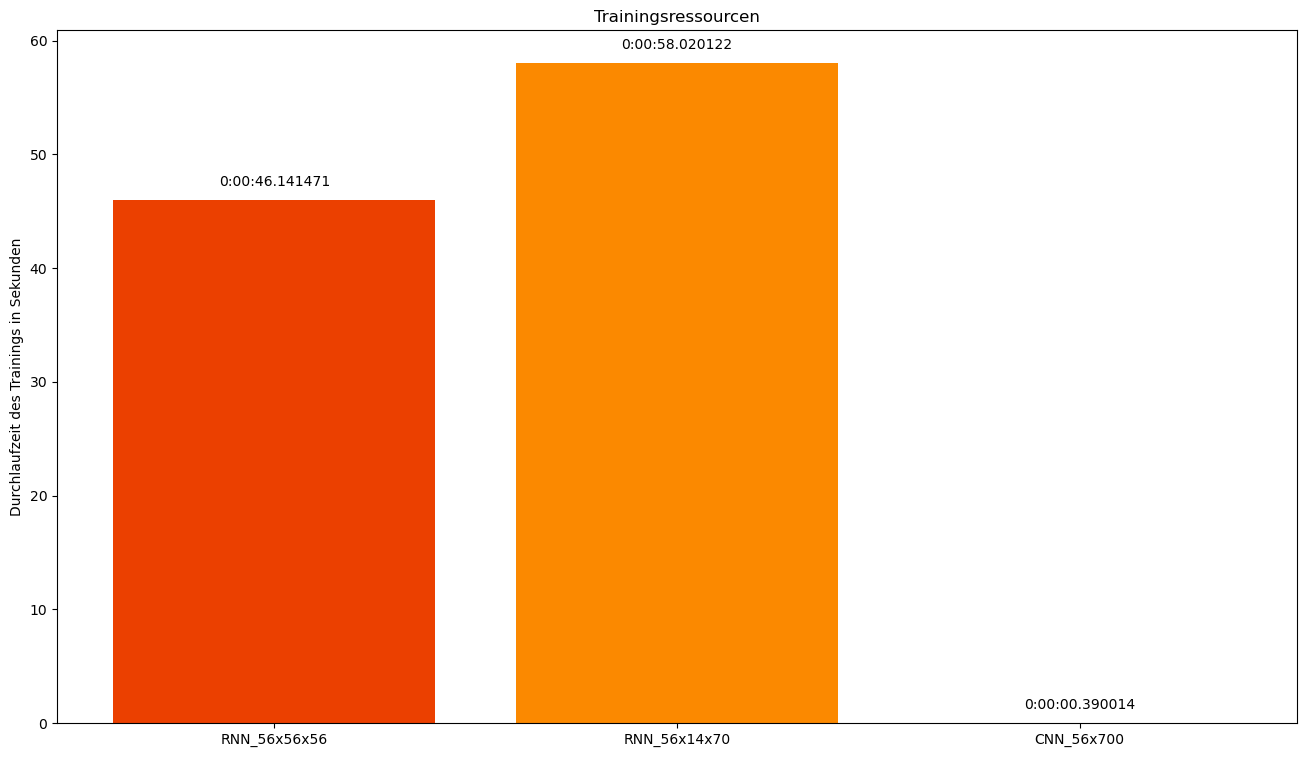

In [30]:

# --- Balkendiagramm mit der Trainingszeit in Sekunden
models = [rnn_model_name, rnn_s_model_name, cnn_model_name]
model_tain_times = [rnn_train_time, rnn_s_train_time, cnn_train_time]
model_tain_times_in_seconds = [rnn_train_time.seconds, rnn_s_train_time.seconds, cnn_train_time.seconds]
model_colors = [rnn_model_color, rnn_s_model_color, cnn_model_color]

plt.figure(figsize=(PLOT_WIDTH, PLOT_HEIGHT))
bars=plt.bar(models, model_tain_times_in_seconds, color=model_colors)
# Werte über jedem Balken anzeigen
for bar, time in zip(bars, model_tain_times):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,  # Position über dem Balken
             str(time), ha='center', va='bottom', fontsize=10)  # Zentriert
plt.ylabel('Durchlaufzeit des Trainings in Sekunden')
plt.title('Trainingsressourcen')
plt.show()

#### Lernfortschritt

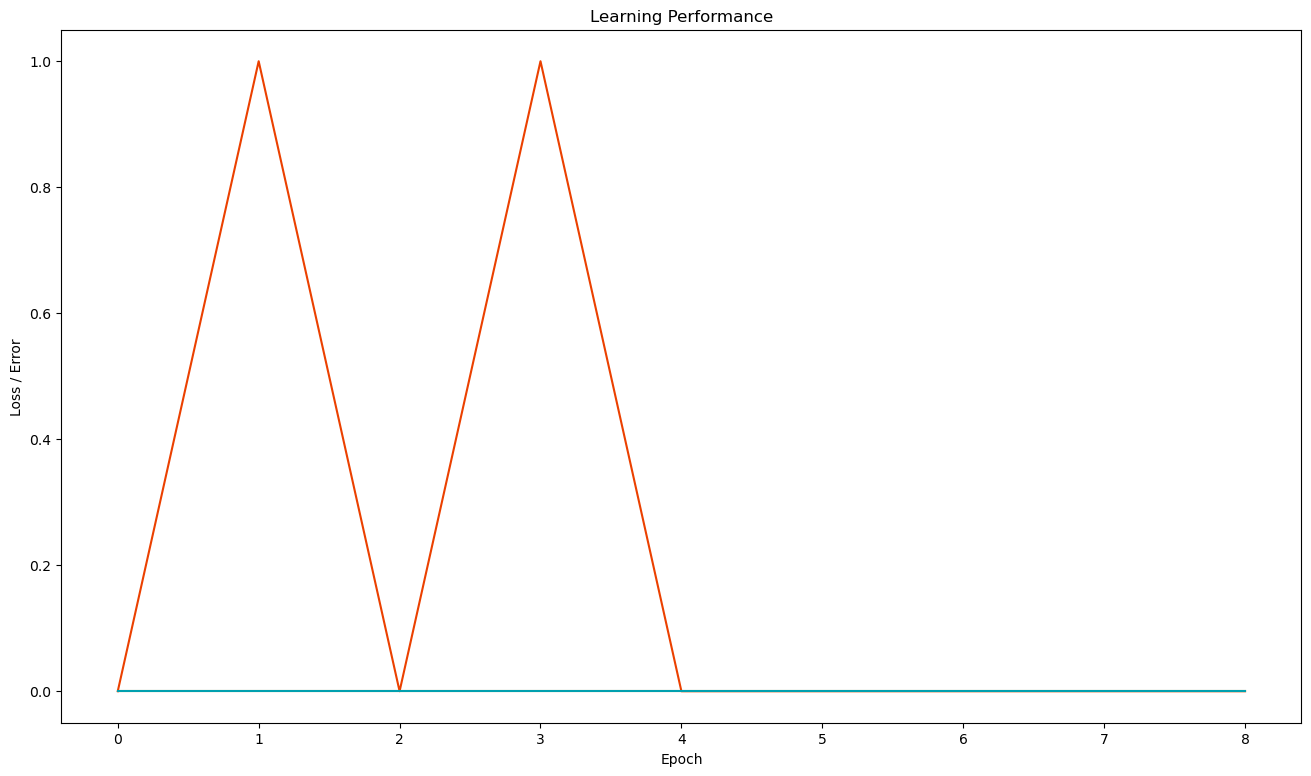

In [35]:
# --- Visualisierung des Lernfortschritts
from turtle import color


plt.figure(figsize=(PLOT_WIDTH, PLOT_HEIGHT))
plt.plot(range(len(rnn_train_performance)), rnn_train_performance, label=rnn_model_name, color=rnn_model_color)
plt.plot(range(len(rnn_s_train_performance)), rnn_s_train_performance, label=rnn_s_model_name, color=rnn_s_model_color)
plt.plot(range(len(cnn_train_performance)), cnn_train_performance, label=cnn_model_name, color=cnn_model_color)
plt.xlabel('Epoch')
plt.ylabel('Loss / Error')
plt.title('Learning Performance')
plt.show()

#### Accuracy im Vergleich

#### Confusion Matrix

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Beispiel: Vorhersagen und echte Werte

# Confusion Matrix berechnen
cm = confusion_matrix(expected_values, predictions)

# Heatmap zeichnen
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Fazit